In [1]:
import os
import sys

sys.path.insert(0, "../../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import ARDL, VAR
from statsmodels.tsa.ardl import ardl_select_order
from sklearn.decomposition import PCA
from src.text.epu import EPU
from src.text.gui import DrawTopics
from src.tourism.ts_utils import get_adf_df
from src.google_trends import GT
from dotenv import load_dotenv

load_dotenv()

True

## EPU

In [2]:
data_dir = sys.path[0] + "/data/text/solomon_islands/"
target_dir = sys.path[0] + "/outputs/text/solomon_islands/"

data_files = [
    data_dir + file for file in os.listdir(data_dir) if "news" in file
    and "ner" not in file
]

ner_files = [
    data_dir + file for file in os.listdir(data_dir) if "ner" in file
]

In [3]:
urls_to_exclude = []
for file in ner_files:
    df = pd.read_csv(file)
    df["ner"] = df["ner"].str.lower()
    urls = [
        url for ner, url in zip(df["ner"], df["url"])
        if "risk" in str(ner) or "uncertain" in str(ner)
    ]
    urls_to_exclude.extend(urls)

In [4]:
si_cpi = [
    98.6, 99.0, 100.6, 100.7, 101.0, 100.6, 100.5, 100.1, 99.5, 99.6, 99.5,
    100.3, 102.0, 104.2, 103.9, 103.9, 103.0, 102.8, 103.0, 103.2, 104.1,
    104.0, 104.3, 104.4, 104.9, 104.1, 105.7, 104.8, 105.0, 105.1, 105.7,
    105.9, 106.3, 107.0, 107.5, 107.5, 114.2, 114.3, 114.1, 113.4, 112.2,
    107.6, 106.1, 105.3, 105.7, 105.6, 106.0, 104.5, 107.8, 111.6, 113.8,
    111.1, 110.8, 107.6, 106.9, 107.3, 108.0, 108.1, 108.2, 108.7, 109.8,
    110.4, 110.5, 112.7, 114.1, 114.3, 115.6, 117.6, 118.5, 119.8, 119.3,
    118.6, 120.3, 120.1, 120.0, 119.9, 119.6, 119.8, 120.9, 120.7, 120.9
]

si_cpi_df = pd.DataFrame(pd.date_range("2017-01", "2023-09", freq="MS"),
                         columns=["date"])
si_cpi_df["cpi"] = si_cpi

In [4]:
e = EPU(data_files, cutoff="2019-12-31", non_epu_urls=urls_to_exclude)
e.get_epu_category("date >= '2015-01-01' and date < '2024-01-01'")
e.get_count_stats()
e.calculate_epu_score()
epu = e.epu_stats

In [31]:
epu.iloc[100]

date                              2023-05-01 00:00:00
ym                                             2023-5
sibc_news_count                                  57.0
sibc_epu_count                                    4.0
sibc_ratio                                   0.070175
solomon_islands_abc_news_count                    1.0
solomon_islands_abc_epu_count                     0.0
solomon_islands_abc_ratio                         0.0
solomon_islands_rnz_news_count                    2.0
solomon_islands_rnz_epu_count                     0.0
solomon_islands_rnz_ratio                         0.0
solomon_times_news_count                         81.0
solomon_times_epu_count                           4.0
solomon_times_ratio                          0.049383
island_sun_news_count                            20.0
island_sun_epu_count                              1.0
island_sun_ratio                                 0.05
solomon_star_news_count                          96.0
solomon_star_epu_count      

In [33]:
sibc = e.raw_files[0][1]
sibc[(sibc.date >= "2023-04-01") & sibc.epu]

,url,title,date,news,tags,ym,econ,policy,uncertain,epu
95,https://www.sibconline.com.sb/solomon-airlines...,Solomon Airlines acquires second aircraft,2023-07-21,solomon airlines has purchased its second inte...,"Airlines, Economy, Solomon Airlines, Solomon I...",2023-7,True,True,True,True
111,https://www.sibconline.com.sb/sig-and-eu-sign-...,SIG and EU sign Financing Agreement for EUR 6....,2023-07-11,minister for national planning and development...,"Climate Change, Government",2023-7,True,True,True,True
162,https://www.sibconline.com.sb/sogavare-commend...,Sogavare commends PNA for sustainable manageme...,2023-06-15,prime minister manasseh sogavare has highly co...,"Government, PNA",2023-6,True,True,True,True
168,https://www.sibconline.com.sb/australian-high-...,AUSTRALIAN HIGH COMMISSIONER HANDS OVER WATER ...,2023-06-13,on the second day of his visit to makira-ulawa...,"Australia, Australian Government",2023-6,True,True,True,True
204,https://www.sibconline.com.sb/pm-sogavare-leav...,PM SOGAVARE LEAVES FOR SOUTH KOREA-PIF SUMMIT,2023-05-27,prime minister manasseh sogavare\nprime minist...,Government,2023-5,True,True,True,True
220,https://www.sibconline.com.sb/japan-to-assist-...,JAPAN TO ASSIST SOLOMON ISLANDS WITH UXO REMOVAL,2023-05-17,"deputy secretary cornelius walegerea, minister...","Bilateral Partnership, Japanese Embassy, Polic...",2023-5,True,True,True,True
224,https://www.sibconline.com.sb/solomon-islands-...,SOLOMON ISLANDS LEADS THE PACIFIC ON SOE PROFI...,2023-05-14,solomon islands’ robust legal framework for st...,"ADB, SOEs",2023-5,True,True,True,True
247,https://www.sibconline.com.sb/food-safety-trai...,Food safety training ends in Honiara with dema...,2023-05-02,a training on the importance of compliance and...,"Economy, Exports, Foreign Affairs, Health",2023-5,True,True,True,True
278,https://www.sibconline.com.sb/solomon-islands-...,Solomon Islands Ambassador in Brussels express...,2023-04-21,solomon islands ambassador to the kingdom of b...,"FAO, Food Security",2023-4,True,True,True,True


In [30]:
sibc[(sibc.date >= "2023-04-01") & sibc.epu]["url"][271]

'https://theislandsun.com.sb/big-ones-blamed/'

## GUI

In [6]:
inflation_prompts = [
    "inflation", "CPI", "food price", "purchasing power"
]
GoogleAPIkey = os.getenv("GoogleAPIkey")
gt = GT(GoogleAPIkey)

dnx = DrawTopics(inflation_prompts, "SB", gt)
dnx.trends_to_nx_object()
words_df = dnx.result
inflation_words = words_df[words_df.volume >= 5]["target"].unique().tolist()

In [7]:
local_trends = pd.DataFrame()
for word in inflation_words:
    r = gt.get_graph(word, "SB", "2016-01")
    r_df = gt.to_df(r)
    r_df = (r_df.drop("term", axis=1).rename({"value": word.replace(" ", "_")}, axis=1))
    if local_trends.empty:
        local_trends = r_df
    else:
        local_trends = local_trends.merge(r_df, how="left", on="date")

In [8]:
cols = local_trends.columns[~local_trends.columns.isin(["date"])]
local_trends["trends"] = local_trends[cols].sum(axis=1)

## Sentiment

In [9]:
ep_sentiment = (pd.read_csv(target_dir + "sentiment/solomon_islands_sentiment.csv")
                  .drop("Unnamed: 0", axis=1))
si_cpi_df = si_cpi_df.merge(epu[["date", "epu_weighted"]], how="left", on="date")
ep_sentiment["date"] = pd.to_datetime(ep_sentiment["date"])
si_cpi_df = si_cpi_df.merge(ep_sentiment, how="left")
si_cpi_df = si_cpi_df.merge(local_trends[["date", "trends"]], how="left")

In [10]:
si_cpi_df["inflation"] = si_cpi_df["cpi"].diff().div(si_cpi_df["cpi"].shift(1)) * 100
si_cpi_df["score_diff"] = si_cpi_df["score"].diff()
si_cpi_df["epu_ma3"] = si_cpi_df["epu_weighted"].rolling(3).mean()

model_df = si_cpi_df.dropna().reset_index(drop=True)

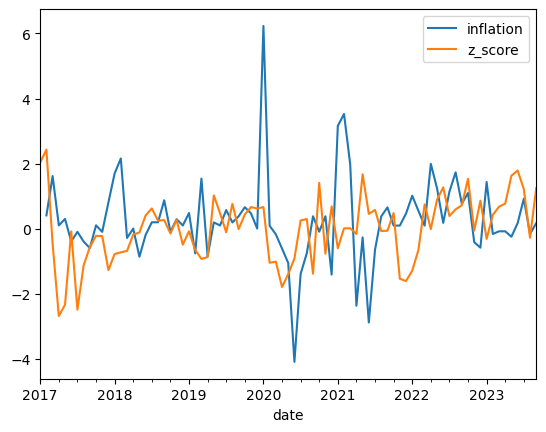

In [11]:
si_cpi_df.plot(x="date", y=["inflation", "z_score"]);

## Modeling
### Stationarity

In [12]:
get_adf_df(model_df, [
    'cpi', 'epu_weighted', "epu_ma3", 'score', 'z_score', 'inflation',
    'score_diff', "trends"
])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value 1%,Critical Value 5%,Critical Value 10%
cpi,-0.861483,8.003919e-01,1.0,77.0,-3.518281,-2.899878,-2.587223
epu_weighted,-3.614446,5.490778e-03,4.0,74.0,-3.521980,-2.901470,-2.588072
epu_ma3,-2.275811,1.798883e-01,7.0,71.0,-3.526005,-2.903200,-2.588995
score,-3.637184,5.088666e-03,1.0,77.0,-3.518281,-2.899878,-2.587223
z_score,-3.637184,5.088666e-03,1.0,77.0,-3.518281,-2.899878,-2.587223
inflation,-7.064806,5.113190e-10,0.0,78.0,-3.517114,-2.899375,-2.586955
score_diff,-5.968593,1.960666e-07,5.0,73.0,-3.523284,-2.902031,-2.588371
trends,-5.311183,5.191019e-06,0.0,78.0,-3.517114,-2.899375,-2.586955


### PCA

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
model_df[["epu_weighted_std", "trends_std"]] = scaler.fit_transform(model_df[["epu_weighted", "trends"]])

In [14]:
pca = PCA(n_components=1)
model_df["pc"] = pca.fit_transform(model_df[["epu_weighted_std", "trends_std"]])
print(pca.explained_variance_ratio_)

[0.64839382]


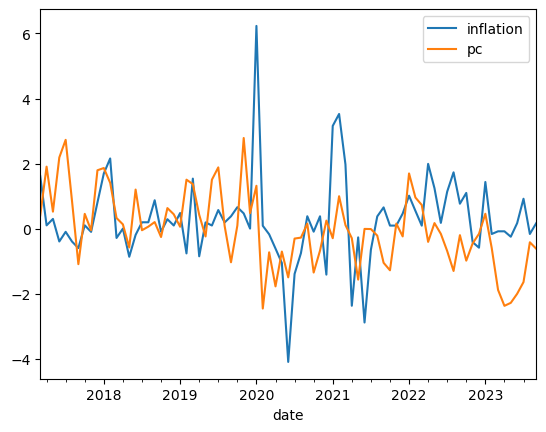

In [15]:
model_df.plot(x="date", y=["inflation", "pc"]);

## VAR(MA)

In [16]:
length = len(model_df)
train = int(length * 0.95)
test = length - train

model = VAR(endog=model_df.loc[:train + 1, ["inflation", "pc"]])

eval_lst = []
for i in range(1, 13):
    result = model.fit(i, trend="c")
    eval_metrics = {
        "lag": i,
        "AIC": result.aic,
        "BIC": result.bic,
        "FPE": result.fpe,
        "HQIC": result.hqic
    }
    eval_lst.append(eval_metrics)

eval_df = pd.DataFrame(eval_lst)
eval_df

,lag,AIC,BIC,FPE,HQIC
0,1,0.592562,0.776567,1.808764,0.666099
1,2,0.633254,0.942252,1.884476,0.756634
2,3,0.718898,1.154802,2.054500,0.892785
3,4,0.668812,1.233583,1.956845,0.893883
4,5,0.639187,1.334835,1.904100,0.916127
5,6,0.643152,1.471739,1.918427,0.972655
6,7,0.617750,1.581391,1.879946,1.000520
7,8,0.663493,1.764357,1.982171,1.100243
8,9,0.649204,1.889517,1.973350,1.140654
9,10,0.780553,2.162599,2.280084,1.327432


In [17]:
res = model.fit(ic="aic", trend="c")
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 12, Mar, 2024
Time:                     14:48:06
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.776567
Nobs:                     76.0000    HQIC:                  0.666099
Log likelihood:          -232.196    FPE:                    1.80876
AIC:                     0.592562    Det(Omega_mle):         1.67400
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.197881         0.151340            1.308           0.191
L1.inflation         0.180413         0.116164            1.553           0.120
L1.pc                0.167860         0.134359            1.

In [18]:
print(res.test_causality("inflation", ["pc"]).summary())
print(res.test_inst_causality("pc").summary())
print(res.test_whiteness().summary())

Granger causality F-test. H_0: pc does not Granger-cause inflation. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.561          3.906   0.214 (1, 146)
----------------------------------------------
Instantaneous causality Wald-test. H_0: pc does not instantaneously cause inflation. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         2.738          3.841   0.098  1
----------------------------------------
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 10 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         45.42          51.00   0.135 36
----------------------------------------


In [21]:
forecast = res.forecast(y=model_df.loc[train:,
                                       ["inflation", "pc"]].values,
                        steps=test)[:, 0]

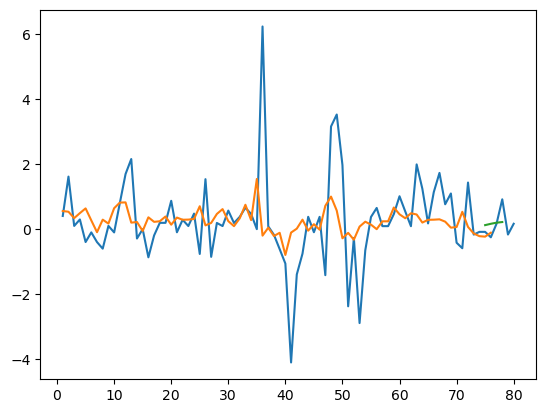

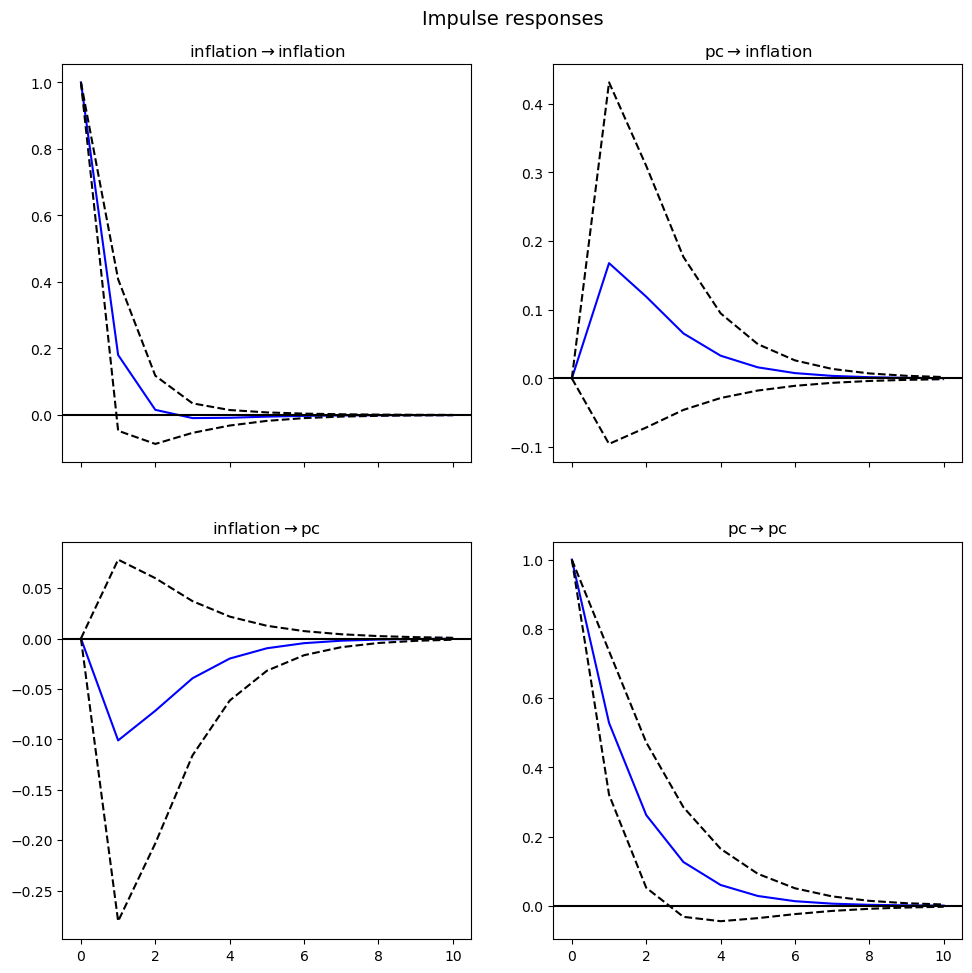

In [22]:
import matplotlib.pyplot as plt
plt.plot(si_cpi_df["inflation"].values)
plt.plot(res.fittedvalues["inflation"]);
plt.plot(model_df.index[-test:], forecast)
res.irf().plot();